<a href="https://colab.research.google.com/github/thopiyawan/topic-modeling-thai/blob/main/run_this_Mask_RCNN_Food_Starter_Codeipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![AIcrowd-Logo](https://raw.githubusercontent.com/AIcrowd/AIcrowd/master/app/assets/images/misc/aicrowd-horizontal.png)

This dataset and notebook correspond to the [Food Recognition Challenge](https://www.aicrowd.com/challenges/food-recognition-challenge) being held on [AICrowd](https://www.aicrowd.com/).

In this Notebook, we will first do an analysis of the Food Recognition Dataset and then use maskrcnn for training on the dataset.

## The Challenge


*   Given Images of Food, we are asked to provide Instance Segmentation over the images for the food items.
*   The Training Data is provided in the COCO format, making it simpler to load with pre-available COCO data processors in popular libraries.
*   The test set provided in the public dataset is similar to Validation set, but with no annotations.
*   The test set after submission is much larger and contains private images upon which every submission is evaluated.
*   Pariticipants have to submit their trained model along with trained weights. Immediately after the submission the AICrowd Grader picks up the submitted model and produces inference on the private test set using Cloud GPUs.
*   This requires Users to structure their repositories and follow a provided paradigm for submission.
*   The AICrowd AutoGrader picks up the Dockerfile provided with the repository, builds it and then mounts the tests folder in the container. Once inference is made, the final results are checked with the ground truth.

***For more submission related information, please check [the AIcrowd Challenge page](https://www.aicrowd.com/challenges/food-recognition-challenge) and [the starter kit](https://github.com/AIcrowd/food-recognition-challenge-starter-kit/).***

## The Notebook
> *  Installation of MaskRCNN
> *  Using MatterPort MaskRCNN Library and Making local inference with it
> *  Local Evaluation Using Matterport MaskRCNN

***A bonus section on other resources to read is also added!***

### Dataset Download

Note: By downloading this data you are argeeing to the competition rules specified [here](https://www.aicrowd.com/challenges/food-recognition-challenge/challenge_rules/150)

In [1]:
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-public-datasets/myfoodrepo/round-2/train.tar.gz
!wget -q https://s3.eu-central-1.wasabisys.com/aicrowd-public-datasets/myfoodrepo/round-2/val.tar.gz

In [2]:
!mkdir data
!mkdir data/val
!mkdir data/train
!tar -xf train.tar.gz -C data/train
!tar -xf val.tar.gz -C data/val

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘data/val’: File exists
mkdir: cannot create directory ‘data/train’: File exists


## Installation


In [3]:
#Directories present
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('data/'):
        print(dirname)

data/
data/train
data/train/images
data/val
data/val/images
data/val/test_images
data/val/test_images/images


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
pip install -q -U numpy==1.16.1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.18.2 requires numpy>=1.17, but you have numpy 1.16.1 which is incompatible.
tensorflow-probability 0.15.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
tensorflow-gpu 1.14.0 requires tensorboard<1.15.0,>=1.14.0, but you have tensorboard 1.15.0 which is incompatible.
tensorflow-gpu 1.14.0 requires tensorflow-estimator<1.15.0rc0,>=1.14.0rc0, but you have tensorflow-estimator 1.15.1 which is incompatible.
scikit-image 0.18.3 requires numpy>=1.16.5, but you have numpy 1.16.1 which is incompatible.
pywavelets 1.2.0 requires numpy>=1.17.3, but you have numpy 1.16.1 which is incompatible.
pyerfa 2.0.0.1 requires numpy>=1.17, but you have numpy 1.16.1 which is incompatible.
pyarrow 3.0.0 requires numpy>=1.16.6, but you have numpy 1.16.1 which is incompatible.
kapre 0.3.6 requires numpy>=1.1

In [6]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

In [7]:
!pip install -q tensorflow-gpu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 1.15.0 requires tensorboard<1.16.0,>=1.15.0, but you have tensorboard 1.14.0 which is incompatible.
tensorflow 1.15.0 requires tensorflow-estimator==1.15.1, but you have tensorflow-estimator 1.14.0 which is incompatible.
kapre 0.3.6 requires numpy>=1.18.5, but you have numpy 1.16.1 which is incompatible.
kapre 0.3.6 requires tensorflow>=2.0.0, but you have tensorflow 1.15.0 which is incompatible.


In [8]:
!pip uninstall keras-nightly
!pip uninstall -y tensorflow
!pip install h5py==2.10.0
!pip install tensorflow==1.15
!pip install tensorflow-gpu==1.14.0
!pip install keras==2.1.6

Found existing installation: tensorflow 1.15.0
Uninstalling tensorflow-1.15.0:
  Successfully uninstalled tensorflow-1.15.0
  Using cached tensorflow-1.15.0-cp37-cp37m-manylinux2010_x86_64.whl (412.3 MB)
  Using cached tensorflow_estimator-1.15.1-py2.py3-none-any.whl (503 kB)
  Using cached tensorboard-1.15.0-py3-none-any.whl (3.8 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tensorflow-estimator-1.14.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 1.14.0 requires tensorboard<1.15.0,>=1.14.0, but you have tensorboard 1.15.0 which is i

In [9]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [10]:
DATA_DIR = 'data'
# Directory to save logs and trained model
ROOT_DIR = 'working'

In [11]:
# https://github.com/matterport/Mask_RCNN

In [12]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
!pip install -q -r requirements.txt
!python setup.py -q install

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
tensorflow-probability 0.15.0 requires gast>=0.3.2, but you have gast 0.2.2 which is incompatible.
tensorflow-gpu 1.14.0 requires tensorboard<1.15.0,>=1.14.0, but you have tensorboard 1.15.0 which is incompatible.
tensorflow-gpu 1.14.0 requires tensorflow-estimator<1.15.0rc0,>=1.14.0rc0, but you have tensorflow-estimator 1.15.1 which is incompatible.
kapre 0.3.6 requires tensorflow>=2.0.0, but you have tensorflow 1.15.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
/

In [13]:
# Import Mask RCNN
sys.path.append(os.path.join('.', 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [14]:
!pip uninstall pycocotools -y
# !pip install -q git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI
!pip install pycocotools

Found existing installation: pycocotools 2.0.3
Uninstalling pycocotools-2.0.3:
  Successfully uninstalled pycocotools-2.0.3
  Using cached pycocotools-2.0.3-cp37-cp37m-linux_x86_64.whl


In [15]:
from mrcnn import utils
import numpy as np

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils


## MaskRCNN

To train MaskRCNN, two things we have to define `FoodChallengeDataset` that implements the `Dataset` class of MaskRCNN and `FoodChallengeConfig` that implements the `Config` class.

The `FoodChallengeDataset` helps define certain functions that allow us to load the data. 

The `FoodChallengeConfig` gives the information like `NUM_CLASSES`, `BACKBONE`, etc.

In [16]:
class FoodChallengeDataset(utils.Dataset):
    def load_dataset(self, dataset_dir, load_small=False, return_coco=True):
        """ Loads dataset released for the AICrowd Food Challenge
            Params:
                - dataset_dir : root directory of the dataset (can point to the train/val folder)
                - load_small : Boolean value which signals if the annotations for all the images need to be loaded into the memory,
                               or if only a small subset of the same should be loaded into memory
        """
        self.load_small = load_small
        if self.load_small:
            annotation_path = os.path.join(dataset_dir, "annotation-small.json")
        else:
            annotation_path = os.path.join(dataset_dir, "annotations.json")

        image_dir = os.path.join(dataset_dir, "images")
        print("Annotation Path ", annotation_path)
        print("Image Dir ", image_dir)
        assert os.path.exists(annotation_path) and os.path.exists(image_dir)

        self.coco = COCO(annotation_path)
        self.image_dir = image_dir

        # Load all classes (Only Building in this version)
        classIds = self.coco.getCatIds()

        # Load all images
        image_ids = list(self.coco.imgs.keys())

        # register classes
        for _class_id in classIds:
            self.add_class("crowdai-food-challenge", _class_id, self.coco.loadCats(_class_id)[0]["name"])

        # Register Images
        for _img_id in image_ids:
            assert(os.path.exists(os.path.join(image_dir, self.coco.imgs[_img_id]['file_name'])))
            self.add_image(
                "crowdai-food-challenge", image_id=_img_id,
                path=os.path.join(image_dir, self.coco.imgs[_img_id]['file_name']),
                width=self.coco.imgs[_img_id]["width"],
                height=self.coco.imgs[_img_id]["height"],
                annotations=self.coco.loadAnns(self.coco.getAnnIds(
                                            imgIds=[_img_id],
                                            catIds=classIds,
                                            iscrowd=None)))

        if return_coco:
            return self.coco

    def load_mask(self, image_id):
        """ Loads instance mask for a given image
              This function converts mask from the coco format to a
              a bitmap [height, width, instance]
            Params:
                - image_id : reference id for a given image

            Returns:
                masks : A bool array of shape [height, width, instances] with
                    one mask per instance
                class_ids : a 1D array of classIds of the corresponding instance masks
                    (In this version of the challenge it will be of shape [instances] and always be filled with the class-id of the "Building" class.)
        """

        image_info = self.image_info[image_id]
        assert image_info["source"] == "crowdai-food-challenge"

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "crowdai-food-challenge.{}".format(annotation['category_id']))
            if class_id:
                m = self.annToMask(annotation,  image_info["height"],
                                                image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue

                # Ignore the notion of "is_crowd" as specified in the coco format
                # as we donot have the said annotation in the current version of the dataset

                instance_masks.append(m)
                class_ids.append(class_id)
        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids
        else:
            # Call super class to return an empty mask
            return super(FoodChallengeDataset, self).load_mask(image_id)


    def image_reference(self, image_id):
        """Return a reference for a particular image

            Ideally you this function is supposed to return a URL
            but in this case, we will simply return the image_id
        """
        return "crowdai-food-challenge::{}".format(image_id)
    # The following two functions are from pycocotools with a few changes.

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

In [17]:
class FoodChallengeConfig(Config):
    """Configuration for training on data in MS COCO format.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "crowdai-food-challenge"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 4

    # Uncomment to train on 8 GPUs (default is 1)
    GPU_COUNT = 1
    BACKBONE = 'resnet50'
    # Number of classes (including background)
    NUM_CLASSES = 62  # 1 Background + 61 classes

    STEPS_PER_EPOCH=150
    VALIDATION_STEPS=50

    LEARNING_RATE=0.001
    IMAGE_MAX_DIM=256
    IMAGE_MIN_DIM=256


In [18]:
config = FoodChallengeConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                74
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

You can change other values in the `FoodChallengeConfig` as well and try out different combinations for best results!

In [19]:
!mkdir pretrained

In [20]:
PRETRAINED_MODEL_PATH = os.path.join("pretrained", "mask_rcnn_coco.h5")
LOGS_DIRECTORY = os.path.join(ROOT_DIR, "logs")

In [21]:
if not os.path.exists(PRETRAINED_MODEL_PATH):
    utils.download_trained_weights(PRETRAINED_MODEL_PATH)

... done downloading pretrained model!


In [22]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [23]:
import keras.backend
K = keras.backend.backend()
if K=='tensorflow':
    keras.backend.common.image_dim_ordering()
model = modellib.MaskRCNN(mode="training", config=config, model_dir=LOGS_DIRECTORY)
model_path = PRETRAINED_MODEL_PATH
model.load_weights(model_path, by_name=True, exclude=[
        "mrcnn_class_logits", "mrcnn_bbox_fc",
        "mrcnn_bbox", "mrcnn_mask"])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead




In [24]:
dataset_train = FoodChallengeDataset()
dataset_train.load_dataset('/content/data/train', load_small=False)
dataset_train.prepare()

Annotation Path  /content/data/train/annotations.json
Image Dir  /content/data/train/images
loading annotations into memory...
Done (t=0.63s)
creating index...
index created!


In [25]:
dataset_val = FoodChallengeDataset()
val_coco = dataset_val.load_dataset(dataset_dir='/content/data/val', load_small=False, return_coco=True)
dataset_val.prepare()

Annotation Path  /content/data/val/annotations.json
Image Dir  /content/data/val/images
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [26]:
class_names = dataset_train.class_names
# If you don't have the correct classes here, there must be some error in your DatasetConfig
assert len(class_names)==62, "Please check DatasetConfig"
class_names

['BG',
 'water',
 'pizza-margherita-baked',
 'broccoli',
 'salad-leaf-salad-green',
 'zucchini',
 'egg',
 'butter',
 'bread-white',
 'apple',
 'dark-chocolate',
 'white-coffee-with-caffeine',
 'sweet-pepper',
 'mixed-salad-chopped-without-sauce',
 'tomato-sauce',
 'bread-wholemeal',
 'coffee-with-caffeine',
 'cucumber',
 'cheese',
 'pasta-spaghetti',
 'rice',
 'salmon',
 'carrot',
 'onion',
 'mixed-vegetables',
 'espresso-with-caffeine',
 'banana',
 'strawberries',
 'mayonnaise',
 'almonds',
 'wine-white',
 'hard-cheese',
 'ham-raw',
 'tomato',
 'french-beans',
 'mandarine',
 'wine-red',
 'potatoes-steamed',
 'croissant',
 'salami',
 'boisson-au-glucose-50g',
 'biscuits',
 'corn',
 'leaf-spinach',
 'jam',
 'tea-green',
 'chips-french-fries',
 'parmesan',
 'beer',
 'avocado',
 'bread-french-white-flour',
 'chicken',
 'soft-cheese',
 'tea',
 'sauce-savoury',
 'honey',
 'bread-whole-wheat',
 'bread-sourdough',
 'gruyere',
 'pickle',
 'mixed-nuts',
 'water-mineral']

#### Lets start training!!

In [27]:
print("Training network")
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=15,
            layers='heads')

Training network

Starting at epoch 0. LR=0.001

Checkpoint Path: working/logs/crowdai-food-challenge20211207T0441/mask_rcnn_crowdai-food-challenge_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4

In [28]:
model_path = model.find_last()
model_path

'working/logs/crowdai-food-challenge20211207T0441/mask_rcnn_crowdai-food-challenge_0015.h5'

In [29]:
class InferenceConfig(FoodChallengeConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 62  # 1 Background + 61 classes
    IMAGE_MAX_DIM=256
    IMAGE_MIN_DIM=256
    NAME = "food"
    DETECTION_MIN_CONFIDENCE=0

inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                74
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [30]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  working/logs/crowdai-food-challenge20211207T0441/mask_rcnn_crowdai-food-challenge_0015.h5
Re-starting from epoch 15


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


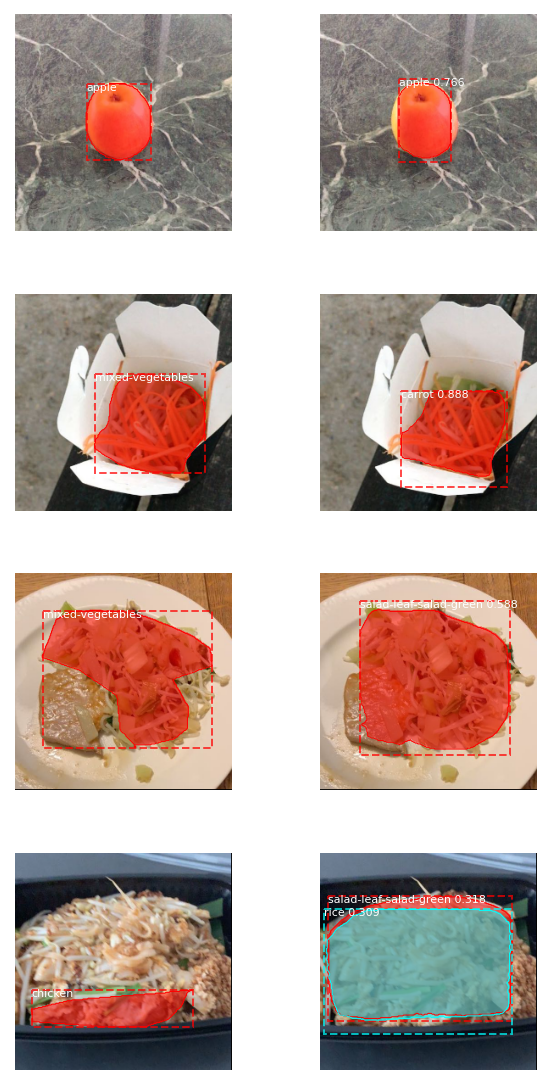

In [31]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(4):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names, ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], ax=fig.axes[-1])

In [32]:
import json
with open('/content/data/val/annotations.json') as json_file:
    data = json.load(json_file)

In [33]:
d = {}
for x in data["categories"]:
    d[x["name"]]=x["id"]

In [34]:
id_category = [0]
for x in dataset.class_names[1:]:
    id_category.append(d[x])
#id_category

In [35]:
import tqdm
import skimage

In [36]:
files = glob.glob(os.path.join('/content/data/val/test_images/images', "*.jpg"))
_final_object = []
for file in tqdm.tqdm(files):
    images = [skimage.io.imread(file) ]
    #if(len(images)!= inference_config.IMAGES_PER_GPU):
    #    images = images + [images[-1]]*(inference_config.BATCH_SIZE - len(images))
    predictions = model.detect(images, verbose=0)
    #print(file)
    for _idx, r in enumerate(predictions):
        
            image_id = int(file.split("/")[-1].replace(".jpg",""))
            for _idx, class_id in enumerate(r["class_ids"]):
                if class_id > 0:
                    mask = r["masks"].astype(np.uint8)[:, :, _idx]
                    bbox = np.around(r["rois"][_idx], 1)
                    bbox = [float(x) for x in bbox]
                    _result = {}
                    _result["image_id"] = image_id
                    _result["category_id"] = id_category[class_id]
                    _result["score"] = float(r["scores"][_idx])
                    _mask = maskUtils.encode(np.asfortranarray(mask))
                    _mask["counts"] = _mask["counts"].decode("UTF-8")
                    _result["segmentation"] = _mask
                    _result["bbox"] = [bbox[1], bbox[0], bbox[3] - bbox[1], bbox[2] - bbox[0]]
                    _final_object.append(_result)

fp = open('/content/output.json', "w")
import json
print("Writing JSON...")
fp.write(json.dumps(_final_object))
fp.close()

100%|██████████| 418/418 [01:30<00:00,  4.63it/s]

Writing JSON...


In [37]:
submission_file = json.loads(open("/content/output.json").read())
len(submission_file)

819

In [38]:
type(submission_file)

list

In [39]:
import random
import json
import numpy as np
import argparse
import base64
import glob
import os
from PIL import Image

from pycocotools.coco import COCO
GROUND_TRUTH_ANNOTATION_PATH = "/content/data/val/annotations.json"
ground_truth_annotations = COCO(GROUND_TRUTH_ANNOTATION_PATH)
submission_file = json.loads(open("/content/output.json").read())
results = ground_truth_annotations.loadRes(submission_file)
cocoEval = COCOeval(ground_truth_annotations, results, 'segm')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.57s).
Accumulating evaluation results...
DONE (t=0.40s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.070
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.112
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.024
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.072
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.111
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.112
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

### **BONUS :** Resources to Read


* [An Introduction to Image Segmentation](https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/)
* [Blog introducing Mask RCNN in COCO dataset](https://www.analyticsvidhya.com/blog/2019/07/computer-vision-implementing-mask-r-cnn-image-segmentation/)
* [A good blog by matterport on Mask RCNN and it's implementation](https://engineering.matterport.com/splash-of-color-instance-segmentation-with-mask-r-cnn-and-tensorflow-7c761e238b46)
* [Using mmdetection library in Pytorch](https://github.com/open-mmlab/mmdetection/blob/master/docs/GETTING_STARTED.md)
